In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2, rankdata, f, t
import typing
import plotly.graph_objs as go
from plotly import express as px
from plotly.subplots import make_subplots
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from umap import UMAP

import warnings, os
import mysql.connector as mysql
warnings.filterwarnings('ignore')
username = os.environ['MYSQL_user']
password = os.environ['MYSQL_password']
DB = mysql.connect(host = "localhost", user = username, passwd = password, database = "AIRBNB")
cursor = DB.cursor(buffered=True)
SEED = 17

## Utils

In [2]:
def read_table_from_db(table_name):
    df = pd.read_sql(f'SELECT * FROM {table_name}', con=DB)
    return df

In [3]:
def base_information(data):
    df =  pd.DataFrame(data.dtypes, columns=['dtypes'])
    df['Number of missing values'] = data.isna().sum()
    df['Percentage of missing values'] = data.isna().sum()/data.shape[0]
    df['Unique values'] = data.nunique().values
    df['Count'] = data.count().values
    return df.style.background_gradient(cmap='Blues')

# Load dataset

In [4]:
listings = read_table_from_db('listings_eda')
location_features = read_table_from_db('location_features')
data = listings.merge(location_features, on='listing_id')
data.head()

,listing_id,listing_url,host_is_superhost,host_has_profile_pic,host_identity_verified,accommodates,bedrooms,beds,minimum_nights,maximum_nights,...,number_of_education_institutions_within_100m,distance_to_nearest_cultural_institution_m,number_of_cultural_institutions_within_100m,distance_to_nearest_recreation_point_m,number_of_recreation_points_within_100m,distance_to_nearest_religious_institution_m,number_of_religious_institutions_within_100m,distance_to_nearest_health_institution_m,number_of_health_institutions_within_100m,distance_to_nearest_main_attraction_m
0,2595,https://www.airbnb.com/rooms/2595,0,1,1,1.0,0.0,1.0,30.0,1125.0,...,0,264.899,0,74.9974,1,113.311,0,748.997,0,497.315
1,5121,https://www.airbnb.com/rooms/5121,0,1,1,2.0,1.0,1.0,30.0,150.0,...,1,114.917,0,157.0960,0,143.338,0,798.512,0,5687.510
2,5136,https://www.airbnb.com/rooms/5136,0,1,1,4.0,2.0,2.0,30.0,730.0,...,1,419.009,0,375.3300,0,201.431,0,607.539,0,5139.470
3,6848,https://www.airbnb.com/rooms/6848,1,1,1,3.0,2.0,1.0,30.0,730.0,...,1,441.078,0,122.0370,0,489.013,0,867.072,0,5022.830
4,6872,https://www.airbnb.com/rooms/6872,0,1,1,1.0,1.0,1.0,30.0,180.0,...,0,571.057,0,108.9370,0,157.284,0,262.918,0,2800.150


## Setting index

In [6]:
data.set_index('listing_id', inplace=True)

## Drop unused columns

In [7]:
data.drop(["listing_url", "geometry"], axis=1, inplace=True)

In [8]:
base_information(data)

,dtypes,Number of missing values,Percentage of missing values,Unique values,Count
host_is_superhost,int64,0,0.000000,2,32822
host_has_profile_pic,int64,0,0.000000,2,32822
host_identity_verified,int64,0,0.000000,2,32822
accommodates,float64,0,0.000000,16,32822
bedrooms,float64,0,0.000000,14,32822
beds,float64,0,0.000000,19,32822
minimum_nights,float64,0,0.000000,23,32822
maximum_nights,float64,0,0.000000,223,32822
availability_30,float64,0,0.000000,31,32822
availability_365,float64,0,0.000000,366,32822


**Notes:**
- There are more than 100 columns in my dataset, at some stage of project I will drop some of them to avoid curse of dimensionality.
- There are features that contain many unique values and have (mostly) float data type (continuous features), but also some that I have converted in previous notebooks to binary features (representing one category of discrete feature).

**Conclusion:**
- I will create two lists with names of: continous and categorical features.

In [9]:
target_feature = "log_price"
categorical_features = data.columns[data.nunique() == 2].tolist()
continuous_features = data.columns.drop(categorical_features + [target_feature]).tolist()
independent_features = continuous_features + categorical_features

# Statistical analysis

## Categorical features

We will start our statistical analysis with categorical features.

## ANOVA

We can use ANOVA test to check whether the means of continous (target) variable are equal for different groups of categorical variable.

If the means are equal this could mean that independent variables might not be important, because for each group of this variable the distribution of target is the same.

Before using ANOVA we have to use check whether the assumptions are met.

First assumption is: analyzed variable has normal distribution within each group.

To test that, we will use Jarque-Bera test.

In [10]:
class JarqueBera:
    def check_data(
        self, data: typing.Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """
        Check if the data is in the right format.

        Args:
            data (Union[pd.DataFrame, pd.Series, np.ndarray]): data to be checked.

        Returns:
            data (np.ndarray): one dimensional numpy array data.
        """
        if (
            not isinstance(data, pd.DataFrame)
            and not isinstance(data, pd.Series)
            and not isinstance(data, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of data. It should be pandas DataFrame, pandas Series or numpy array."
            )
        data = np.array(data)
        if data.ndim == 2:
            data = data.squeeze()
        return data

    def check_for_object_columns(self, data: np.ndarray) -> np.ndarray:
        """
        Check if the data contains object columns.

        Args:
            data (np.ndarray): data to be checked.

        Returns:
            data (np.ndarray): data after checking for object columns.
        """
        data = pd.DataFrame(data)
        if data.select_dtypes(include=np.number).shape[1] != data.shape[1]:
            raise TypeError(
                "Your data contains object or string columns. Numeric data is obligated."
            )
        return np.array(data)

    def fit(
        self,
        data: typing.Union[pd.DataFrame, pd.Series, np.ndarray],
        alpha: float = 0.05,
    ):
        """
        Perform Jarque Bera test.

        Args:
            data (Union[pd.DataFrame, pd.Series, np.ndarray]): data to be tested.
            alpha (float): significance level.
        """
        data = self.check_data(data=data)
        data = self.check_for_object_columns(data=data)
        skewness_ = self.calculate_skewness(data=data)
        kurtosis_ = self.calculate_kurtosis(data=data)
        self.test_statistic_ = self.calculate_test_statistic(
            data=data, skewness=skewness_, kurtosis=kurtosis_
        )
        self.p_value_ = self.calculate_p_value(
            test_statistic=self.test_statistic_, df=2
        )
        self.critical_value_ = self.calculate_critical_value(df=2, alpha=alpha)
        self.keep_H0 = self.statistical_inference(p_value=self.p_value_, alpha=alpha)

    def calculate_skewness(self, data: np.ndarray) -> float:
        """
        Calculate skewness of the data.

        Args:
            data (np.ndarray): data to calculate skewness for.

        Returns:
            skewness (float): skewness of the data.
        """
        return np.sum((data - np.mean(data)) ** 3) / (
            (data.shape[0] - 1) * np.std(data) ** 3
        )

    def calculate_kurtosis(self, data: np.ndarray) -> float:
        """
        Calculate kurtosis of the data.

        Args:
            data (np.ndarray): data to calculate kurtosis for.

        Returns:
            kurtosis (float): kurtosis of the data.
        """
        return np.sum((data - np.mean(data)) ** 4) / (
            (data.shape[0] - 1) * np.std(data) ** 4
        )

    def calculate_test_statistic(
        self, data: np.ndarray, skewness: float, kurtosis: float
    ) -> float:
        """
        Calculate test statistic.

        Args:
            data (np.ndarray): data to calculate test statistic for.
            skewness (float): skewness of the data.
            kurtosis (float): kurtosis of the data.

        Returns:
            test_statistic (float): value of test statistic.
        """
        return data.shape[0] / 6 * (skewness**2 + 1 / 4 * (kurtosis - 3) ** 2)

    def calculate_p_value(self, test_statistic: float, df: int) -> float:
        """
        Calculate p value.

        Args:
            test_statistic (float): value of test statistic.
            df (int): degrees of freedom.

        Returns:
            p_value (float): p value.
        """
        return 1 - chi2.cdf(x=test_statistic, df=df)

    def calculate_critical_value(self, df: int, alpha: float) -> float:
        """
        Calculate critical value.

        Args:
            df (int): degrees of freedom.
            alpha (float): significance level.

        Returns:
            critical_value (float): critical value.
        """
        return chi2.isf(q=alpha, df=df)

    def statistical_inference(self, p_value: float, alpha: float) -> bool:
        """
        Perform statistical inference.

        Args:
            p_value: (float): p value.
            alpha: (float): significance level.
        
        Returns:
            bool: (bool): True if H0 is not rejected, False otherwise.
        """
        if p_value >= alpha:
            return True
        else:
            return False
jarque_bera_test = JarqueBera()

In [11]:
jarque_bera_test.fit(data=data[target_feature])
if jarque_bera_test.keep_H0:
    print("The target feature is normally distributed.")
else:
    print("The target feature is not normally distributed.")
print(f"Test statistic: {jarque_bera_test.test_statistic_}\nCritical value: {jarque_bera_test.critical_value_}\np_value: {jarque_bera_test.p_value_}")

The target feature is not normally distributed.
Test statistic: 2232.260156859587
Critical value: 5.991464547107983
p_value: 0.0


Well it seems that target variable is not normally distributed in whole dataset, but we will check it for each group of categorical variable.

In [12]:
jarque_bera_results = pd.DataFrame(columns=["Feature", "p_value", "Test statistic", "Critical value", "H0 rejected"])
for feature in categorical_features:
    normal_within_each_group = True
    for category in data[feature].unique():
        target_subset = data[data[feature] == category][target_feature]
        jarque_bera_test.fit(data=target_subset)
        if not jarque_bera_test.keep_H0:
            jarque_bera_results = pd.concat([jarque_bera_results if not jarque_bera_results.empty else None, pd.DataFrame({"Feature": [feature], "p_value": [jarque_bera_test.p_value_], "Test statistic": [jarque_bera_test.test_statistic_], "Critical value": [jarque_bera_test.critical_value_], "H0 rejected": [not jarque_bera_test.keep_H0]})])
            normal_within_each_group = False
            break
    if normal_within_each_group:
        jarque_bera_results = pd.concat([jarque_bera_results if not jarque_bera_results.empty else None, pd.DataFrame({"Feature": [feature], "p_value": [jarque_bera_test.p_value_], "Test statistic": [jarque_bera_test.test_statistic_], "Critical value": [jarque_bera_test.critical_value_], "H0 rejected": [not jarque_bera_test.keep_H0]})])
jarque_bera_results.sort_values(by="Test statistic", ascending=False, inplace=True)
jarque_bera_results.reset_index(drop=True, inplace=True)
print(f"Percantage of features where H0 is not rejected (normal distribution): {jarque_bera_results[jarque_bera_results['H0 rejected'] == False].shape[0]/len(jarque_bera_results)*100:.2f}%")
print(f"Percantage of features where H0 is rejected (not normal distribution): {jarque_bera_results[jarque_bera_results['H0 rejected'] == True].shape[0]/len(jarque_bera_results)*100:.2f}%")
jarque_bera_results

Percantage of features where H0 is not rejected (normal distribution): 0.00%
Percantage of features where H0 is rejected (not normal distribution): 100.00%


,Feature,p_value,Test statistic,Critical value,H0 rejected
0,room_type_Entire_home_apt,0.000000e+00,4270.588101,5.991465,True
1,room_type_Private_room,0.000000e+00,3164.681736,5.991465,True
2,host_response_rate_91_99,0.000000e+00,2713.197481,5.991465,True
3,time_since_first_review_0_6_months,0.000000e+00,2412.616068,5.991465,True
4,is_bathroom_shared,0.000000e+00,2369.905997,5.991465,True
...,...,...,...,...,...
70,review_scores_cleanliness_91_95,0.000000e+00,176.554811,5.991465,True
71,review_scores_accuracy_91_95,0.000000e+00,161.054181,5.991465,True
72,review_scores_checkin_91_95,0.000000e+00,110.697261,5.991465,True
73,review_scores_communication_91_95,0.000000e+00,75.321354,5.991465,True


After investigating the distribution of target variable for each group of categorical variable, we can see that it is not normally distributed in all groups.

That means we will need to use some non-parametric tests.

## Kruskal-Wallis

The Kruskal-Wallis test is used as a substitute for Anova when assumptions are not met.

Instead of comparing means, it compares medians.

In [13]:
class KruskalWallis:
    def check_X(
        self, X: typing.Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """
        Check if X is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            X: (Union[pd.DataFrame, pd.Series, np.ndarray]): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        if (
            not isinstance(X, pd.DataFrame)
            and not isinstance(X, pd.Series)
            and not isinstance(X, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of X. It should be pandas DataFrame, pandas Series, numpy array."
            )
        X = np.array(X)
        if X.ndim != 1:
            X = X.squeeze()
        return X

    def check_y(
        self, y: typing.Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """
        Check if y is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            y: (Union[pd.DataFrame, pd.Series, np.ndarray]): target data.

        Returns:
            y: (np.ndarray): converted target data.
        """
        if (
            not isinstance(y, pd.DataFrame)
            and not isinstance(y, pd.Series)
            and not isinstance(y, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of y. It should be pandas DataFrame, pandas Series, numpy array."
            )
        y = np.array(y)
        if y.ndim != 1:
            y = y.squeeze()
        return y

    def check_for_object_columns(self, X: np.ndarray) -> np.ndarray:
        """
        Check if X contains object columns and convert it to numeric data.

        Args:
            X: (np.ndarray): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        X = pd.DataFrame(X)
        if X.select_dtypes(include=np.number).shape[1] != X.shape[1]:
            raise TypeError(
                "Your data contains object or string columns. Numeric data is obligated."
            )
        return np.array(X)

    def fit(
        self,
        X: typing.Union[pd.DataFrame, pd.Series, np.ndarray],
        y: typing.Union[pd.DataFrame, pd.Series, np.ndarray],
        alpha: float = 0.05,
    ):
        """
        Perform Kruskal Wallis test.

        Args:
            X: (Union[pd.DataFrame, pd.Series, np.ndarray]): input data.
            y: (Union[pd.DataFrame, pd.Series, np.ndarray]): target data.
            alpha (float): significance level.
        """
        X = self.check_X(X)
        X = self.check_for_object_columns(X)
        y = self.check_y(y)
        y_ranked = rankdata(y)
        y_ranked_divided_into_groups = self.divide_into_groups(X=X, y=y_ranked)
        r_c_mean, r_all_mean = self.calculate_rank_means(
            y_ranked=y_ranked_divided_into_groups
        )
        self.test_statistic_ = self.calculate_H_statistic(
            y_ranked=y_ranked_divided_into_groups,
            r_c_mean=r_c_mean,
            r_all_mean=r_all_mean,
        )
        self.p_value_ = self.calculate_p_value_F_test(
            F_test=self.test_statistic_,
            dfn=len(y_ranked_divided_into_groups) - 1,
            dfd=X.shape[0] - len(y_ranked_divided_into_groups),
        )
        self.critical_value_ = self.calculate_critical_value(
            dfn=len(y_ranked_divided_into_groups) - 1,
            dfd=X.shape[0] - len(y_ranked_divided_into_groups),
            alpha=alpha,
        )
        self.keep_H0 = self.statistical_inference(p_value=self.p_value_, alpha=alpha)

    def divide_into_groups(self, X: np.ndarray, y: np.ndarray) -> typing.List:
        """
        Divide the data into groups.

        Args:
            X: (np.ndarray): input data.
            y: (np.ndarray): target data.

        Returns:
            List: data divided into groups.
        """
        return [y[(X == value).squeeze()].flatten().tolist() for value in np.unique(X)]

    def calculate_rank_means(self, y_ranked: typing.List) -> typing.Tuple:
        """
        Calculate mean ranks for each group and all data.

        Args:
            y_ranked: (List): data divided into groups.

        Returns:
            Tuple: mean ranks for each group and all data.
        """
        r_c_mean = []
        C = len(y_ranked)
        for category in range(0, C):
            r_c_mean.append(np.mean(y_ranked[category]))
        flat_list = [item for row in y_ranked for item in row]
        r_all_mean = np.mean(flat_list)
        return r_c_mean, r_all_mean

    def calculate_H_statistic(
        self, y_ranked: typing.List, r_c_mean: typing.List, r_all_mean: float
    ) -> float:
        """
        Calculate H statistic.

        Args:
            y_ranked: (List): data divided into groups.
            r_c_mean: (List): mean ranks for each group.
            r_all_mean: (float): mean rank for all data.

        Returns:
            float: H statistic.
        """
        nominator = 0
        denominator = 0
        N = 0
        C = len(y_ranked)
        for category in range(0, C):
            N += len(y_ranked[category])
            nominator += len(y_ranked[category]) * (
                (r_c_mean[category] - r_all_mean) ** 2
            )
            denominator += np.sum((y_ranked[category] - r_all_mean) ** 2)
        return (N - 1) * nominator / denominator

    def calculate_p_value_F_test(self, F_test: float, dfn: int, dfd: int) -> float:
        """
        Calculate p value for F test.

        Args:
            F_test: (float): F test statistic.
            dfn: (int): degrees of freedom numerator.
            dfd: (int): degrees of freedom denominator.

        Returns:
            float: p value of F test.
        """
        return 1 - f.cdf(F_test, dfn, dfd)

    def calculate_critical_value(self, dfn: int, dfd: int, alpha: float) -> float:
        """
        Calculate critical value.

        Args:
            df: (int): degrees of freedom.
            alpha: (float): significance level.

        Returns:
            critical_value: (float): critical value.
        """
        return f.isf(q=alpha, dfn=dfn, dfd=dfd)

    def statistical_inference(self, p_value: float, alpha: float) -> bool:
        """
        Perform statistical inference.

        Args:
            p_value: (float): p value.
            alpha: (float): significance level.

        Returns:
            bool: (bool): True if H0 is not rejected, False otherwise.
        """
        if p_value >= alpha:
            return True
        else:
            return False
    
kruskal_wallis_test = KruskalWallis()

In [6]:
kruskal_walis_results = pd.DataFrame(columns=["Feature", "p_value", "Test statistic", "Critical value", "H0 rejected"])
for feature in categorical_features:
    kruskal_wallis_test.fit(X=data[feature], y=data[target_feature])
    kruskal_walis_results = pd.concat([kruskal_walis_results if not kruskal_walis_results.empty else None, pd.DataFrame({"Feature": [feature], "p_value": [kruskal_wallis_test.p_value_], "Test statistic": [kruskal_wallis_test.test_statistic_], "Critical value": [kruskal_wallis_test.critical_value_], "H0 rejected": [not kruskal_wallis_test.keep_H0]})])
kruskal_walis_results.sort_values(by="Test statistic", ascending=False, inplace=True)
kruskal_walis_results.reset_index(drop=True, inplace=True)
print(f"Percantage of features where H0 is not rejected (medians are equal): {kruskal_walis_results[kruskal_walis_results['H0 rejected'] == False].shape[0]/len(kruskal_walis_results)*100:.2f}%")
print(f"Percantage of features where H0 is rejected (medians are not equal): {kruskal_walis_results[kruskal_walis_results['H0 rejected'] == True].shape[0]/len(kruskal_walis_results)*100:.2f}%")
kruskal_walis_results

NameError: name 'categorical_features' is not defined

The results show us that some of binary features do not differentiate target variable based on Kruskal-Wallis test.

For some of categorical features we can conclude that the target variable has almost the same distribution within each group of these features.

That's rather not a good sign in terms of future model performance and it indicates that we should consider dropping some of these features.

## Chi square test

Chi square test is used to determine whether there is a significant association between two categorical variables.

Although our target variable is continous, we can create bins and treat it as categorical feature.

Below we will crate a temporary categorical feature based on target variable and then we will use chi square test to check whether there is a significant association between this temporary feature and other categorical features.

The temporary categorized target will have 5 unique values based on quantiles.

In [15]:
data['log_price_bins'] = pd.qcut(data[target_feature], q=5, labels=False)
data['log_price_bins'].value_counts()

log_price_bins
2    6782
0    6657
4    6564
1    6506
3    6313
Name: count, dtype: int64

In [16]:
class Chi_Square_Test:
    def check_X(
        self, X: typing.Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """
        Check if X is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            X: (Union[pd.DataFrame, pd.Series, np.ndarray]): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        if (
            not isinstance(X, pd.DataFrame)
            and not isinstance(X, pd.Series)
            and not isinstance(X, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of X. It should be pandas DataFrame, pandas Series, numpy array."
            )
        X = np.array(X)
        if X.ndim == 1:
            X = X[None, :]
        return X

    def check_y(
        self, y: typing.Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """
        Check if y is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            y: (Union[pd.DataFrame, pd.Series, np.ndarray]): target data.

        Returns:
            y: (np.ndarray): converted target data.
        """
        if (
            not isinstance(y, pd.DataFrame)
            and not isinstance(y, pd.Series)
            and not isinstance(y, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of y. It should be pandas DataFrame, pandas Series, numpy array."
            )
        y = np.array(y)
        if y.ndim != 1:
            y = y.squeeze()
        return y

    def check_for_object_columns(self, X: np.ndarray) -> np.ndarray:
        """
        Check if X contains object columns and convert it to numeric data.

        Args:
            X: (np.ndarray): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        X = pd.DataFrame(X)
        if X.select_dtypes(include=np.number).shape[1] != X.shape[1]:
            raise TypeError(
                "Your data contains object or string columns. Numeric data is obligated."
            )
        return np.array(X)

    def fit(
        self,
        X: typing.Union[pd.DataFrame, pd.Series, np.ndarray],
        y: typing.Union[pd.DataFrame, pd.Series, np.ndarray],
        alpha: float = 0.05,
    ):
        """
        Perform Chi Square test.

        Args:
            X: (Union[pd.DataFrame, pd.Series, np.ndarray]): input data.
            y: (Union[pd.DataFrame, pd.Series, np.ndarray]): target data.
            alpha: (float): significance level.
        """
        X = self.check_X(X)
        X = self.check_for_object_columns(X)
        y = self.check_y(y)
        self.crosstab_ = self.crosstab_creation(X=X, y=y)
        self.check_assumptions(crosstab=self.crosstab_)
        self.test_statistic_ = self.calculate_chi_square_statistic(
            crosstab=self.crosstab_
        )
        self.df_ = self.calculate_degrees_of_freedom(crosstab=self.crosstab_)
        self.p_value_ = self.calculate_p_value(
            test_statistic=self.test_statistic_, df=self.df_
        )
        self.critical_value_ = self.calculate_critical_value(df=self.df_, alpha=alpha)
        self.keep_H0 = self.statistical_inference(p_value=self.p_value_, alpha=alpha)
        self.V_Cramera_ = self.calculate_V_Cramera(
            test_statistic=self.test_statistic_, crosstab=self.crosstab_
        )

    def crosstab_creation(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Create crosstab from input data.

        Args:
            X: (np.ndarray): input data.
            y: (np.ndarray): target data.

        Returns:
            crosstab: (np.ndarray): crosstab.
        """
        return np.array(pd.crosstab(X, y, margins=True))

    def check_assumptions(self, crosstab: np.ndarray) -> bool:
        """
        Check if assumptions for Chi Square test are met.

        Args:
            crosstab: (np.ndarray): crosstab.

        Raises:
            Warning: if assumptions are not met.
        """
        if not all(i <= 5 for i in crosstab.flatten()):
            self.assumption_ = False
            #warnings.warn("Assumptions for Chi Square test are not met.")
        else:
            self.assumption_ = True

    def calculate_chi_square_statistic(self, crosstab: np.ndarray) -> float:
        """
        Calculate Chi Square statistic.

        Args:
            crosstab: (np.ndarray): crosstab.

        Returns:
            chi_square: (float): Chi Square statistic.
        """
        chi_square = 0
        for row in range(0, crosstab.shape[0] - 1):
            for column in range(0, crosstab.shape[1] - 1):
                observed = crosstab[row][column]
                expected = crosstab[row][-1] * crosstab[-1][column] / crosstab[-1][-1]
                chi_square += (observed - expected) ** 2 / expected
        return chi_square

    def calculate_degrees_of_freedom(self, crosstab: np.ndarray) -> int:
        """
        Calculate degrees of freedom.

        Args:
            crosstab: (np.ndarray): crosstab.

        Returns:
            df: (int): degrees of freedom.
        """
        return (crosstab.shape[0] - 2) * (crosstab.shape[1] - 2)

    def calculate_p_value(self, test_statistic: float, df: int) -> float:
        """
        Calculate p value.

        Args:
            test_statistic: (float): test statistic.
            df: (int): degrees of freedom.

        Returns:
            p_value: (float): p value.
        """
        return 1 - chi2.cdf(x=test_statistic, df=df)

    def calculate_critical_value(self, df: int, alpha: float) -> float:
        """
        Calculate critical value.

        Args:
            df: (int): degrees of freedom.
            alpha: (float): significance level.

        Returns:
            critical_value: (float): critical value.
        """
        return chi2.isf(q=alpha, df=df)

    def statistical_inference(self, p_value: float, alpha: float) -> bool:
        """
        Perform statistical inference.

        Args:
            p_value: (float): p value.
            alpha: (float): significance level.

        Returns:
            bool: (bool): True if H0 is not rejected, False otherwise.
        """
        if p_value >= alpha:
            return True
        else:
            return False

    def calculate_V_Cramera(self, test_statistic: float, crosstab: np.ndarray) -> float:
        """
        Calculate V Cramer test statistic.

        Args:
            test_statistic: (float): test statistic.
            crosstab: (np.ndarray): crosstab.

        Returns:
            V_Cramer: (float): V Cramer test statistic.
        """
        return (
            test_statistic
            / (
                crosstab[-1][-1]
                * np.min([crosstab.shape[0] - 2, crosstab.shape[1] - 2])
            )
        ) ** 0.5

chi_square = Chi_Square_Test()

In [17]:
chi_square_results = pd.DataFrame(columns=["Feature", "p_value", "Test statistic", "Critical value", "H0 rejected", "V Cramera"])
for feature in categorical_features:
    chi_square.fit(X=data[feature], y=data['log_price_bins'])
    chi_square_results = pd.concat([chi_square_results if not chi_square_results.empty else None, pd.DataFrame({"Feature": [feature], "p_value": [chi_square.p_value_], "Test statistic": [chi_square.test_statistic_], "Critical value": [chi_square.critical_value_], "H0 rejected": [not chi_square.keep_H0], "V Cramera": [chi_square.V_Cramera_]})])
chi_square_results.sort_values(by="Test statistic", ascending=False, inplace=True)
chi_square_results.reset_index(drop=True, inplace=True)
print(f"Percantage of features where H0 is not rejected (features are NOT associated with log_price): {chi_square_results[chi_square_results['H0 rejected'] == False].shape[0]/len(chi_square_results)*100:.2f}%")
print(f"Percantage of features where H0 is rejected (features are associated with log_price): {chi_square_results[chi_square_results['H0 rejected'] == True].shape[0]/len(chi_square_results)*100:.2f}%")
chi_square_results

Percantage of features where H0 is not rejected (features are NOT associated with log_price): 6.67%
Percantage of features where H0 is rejected (features are associated with log_price): 93.33%


,Feature,p_value,Test statistic,Critical value,H0 rejected,V Cramera
0,room_type_Entire_home_apt,0.000000,11017.432024,9.487729,True,0.579372
1,room_type_Private_room,0.000000,10800.991172,9.487729,True,0.573653
2,is_bathroom_shared,0.000000,10100.102461,9.487729,True,0.554728
3,borough_Manhattan,0.000000,4148.898055,9.487729,True,0.355536
4,borough_Queens,0.000000,1362.027960,9.487729,True,0.203709
...,...,...,...,...,...,...
70,review_scores_communication_91_95,0.060833,9.010701,9.487729,False,0.016569
71,review_scores_communication_81_90,0.089757,8.050173,9.487729,False,0.015661
72,review_scores_accuracy_81_90,0.155545,6.650599,9.487729,False,0.014235
73,review_scores_checkin_81_90,0.470097,3.551461,9.487729,False,0.010402


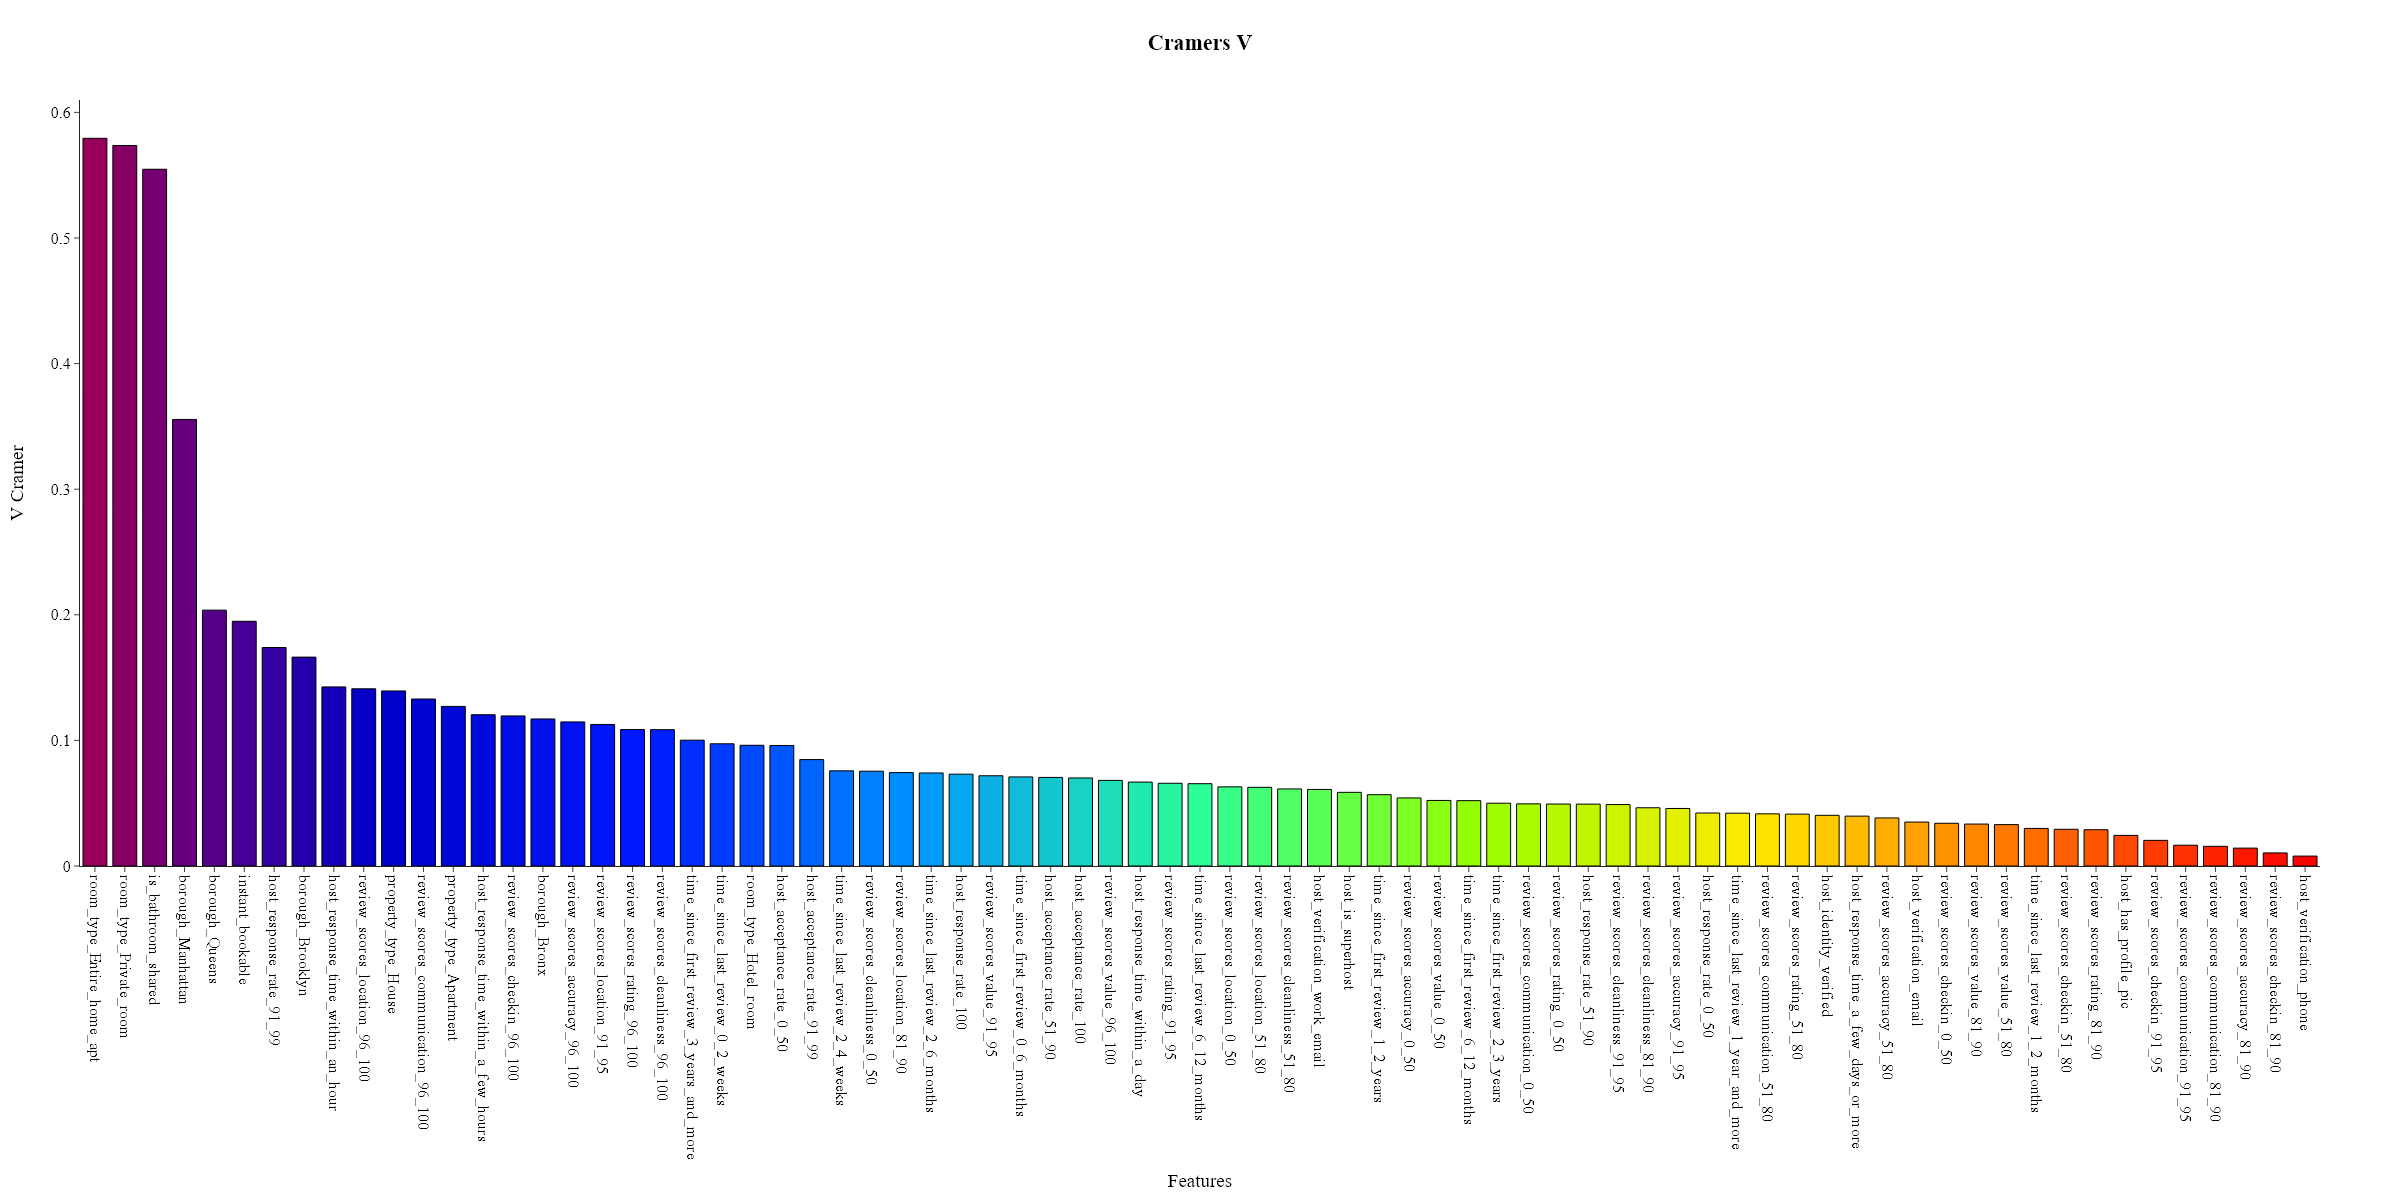

In [18]:
fig = go.Figure()
n_colors = len(chi_square_results)
colors = px.colors.sample_colorscale("rainbow", [n/(n_colors -1) for n in range(n_colors)])
fig.add_trace(go.Bar(x=chi_square_results["Feature"], y=chi_square_results["V Cramera"], marker=dict(color=colors, line=dict(color='black', width=1), line_color='black')))
fig.update_xaxes(title_text="Features")
fig.update_yaxes(title_text="V Cramer")
fig.update_layout(template="simple_white", width=2400, height=1200, title="<b>Cramers V<b>", title_x=0.5, font=dict(family="Times New Roman",size=16,color="Black"))
fig.update_xaxes(tickangle=90)
fig.show("png")

**Notes:**
- There are few features that are not associated with target variable (at least the binned version of it) based on chi square test.
- On the other hand, most of the categorical features have pretty high V Cramer value, which means that they are strongly associated with target variable.

**Conclusion:**
- We will drop `log_price_bins` as it is no longer needed.

In [19]:
data.drop("log_price_bins", axis=1, inplace=True)

## Continous features

After analyzing categorical features, we will move to continous features.

## Correlation tests

Based on the plots of variables in other notebook and results of Jarque-Bera test on target variable, we can assume that most of continous features are not normally distributed.

Therefore I will not use Pearson correlation test, but instead non-parametric - Spearman correlation.

In [20]:
class SpearmanCorrelation:
    def check_X(
        self, X: typing.Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """
        Check if X is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            X: (Union[pd.DataFrame, pd.Series, np.ndarray]): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        if (
            not isinstance(X, pd.DataFrame)
            and not isinstance(X, pd.Series)
            and not isinstance(X, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of X. It should be pandas DataFrame, pandas Series, numpy array."
            )
        X = np.array(X)
        if X.ndim != 1:
            X = X.squeeze()
        return X

    def check_y(
        self, y: typing.Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """
        Check if y is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            y: (Union[pd.DataFrame, pd.Series, np.ndarray]): target data.

        Returns:
            y: (np.ndarray): converted target data.
        """
        if (
            not isinstance(y, pd.DataFrame)
            and not isinstance(y, pd.Series)
            and not isinstance(y, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of y. It should be pandas DataFrame, pandas Series, numpy array."
            )
        y = np.array(y)
        if y.ndim != 1:
            y = y.squeeze()
        return y

    def check_for_object_columns(self, X: np.ndarray) -> np.ndarray:
        """
        Check if X contains object columns and convert it to numeric data.

        Args:
            X: (np.ndarray): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        X = pd.DataFrame(X)
        if X.select_dtypes(include=np.number).shape[1] != X.shape[1]:
            raise TypeError(
                "Your data contains object or string columns. Numeric data is obligated."
            )
        return np.array(X)

    def check_sample_count(self, X1: np.ndarray, X2: np.ndarray) -> None:
        """
        Check if the number of samples in X1 and X2 is the same.

        Args:
            X1 (np.ndarray): feature 1 data.
            X2 (np.ndarray): feature 2 data.
        """
        if X1.shape[0] != X2.shape[0]:
            raise ValueError("The number of samples in X1 and X2 is not the same.")

    def fit(
        self,
        X1: typing.Union[pd.DataFrame, pd.Series, np.ndarray],
        X2: typing.Union[pd.DataFrame, pd.Series, np.ndarray],
        alpha: float = 0.05,
    ) -> None:
        """
        Perform Spearman correlation

        Args:
            X1 (Union[pd.DataFrame, pd.Series, np.ndarray]): feature 1 data.
            X2 (Union[pd.DataFrame, pd.Series, np.ndarray]): feature 2 data.
            alpha (float): significance level.
        """
        X1 = self.check_X(X1)
        X1 = self.check_for_object_columns(X1)
        X2 = self.check_X(X2)
        X2 = self.check_for_object_columns(X2)
        self.check_sample_count(X1=X1, X2=X2)
        ranked_X1 = rankdata(X1)
        ranked_X2 = rankdata(X2)
        covariance = self.calculate_covariance(X1=ranked_X1, X2=ranked_X2)
        std_X1 = self.calculate_std(data=ranked_X1)
        std_X2 = self.calculate_std(data=ranked_X2)
        self.correlation_ = self.calculate_correlation(
            covariance=covariance, std_X1=std_X1, std_X2=std_X2
        )
        self.test_statistic_ = self.calculate_test_statistic(
            correlation=self.correlation_, N=X1.shape[0]
        )
        self.p_value_ = self.calculate_p_value_t_test(
            t_test=self.test_statistic_, df=X1.shape[0] - 2
        )
        self.critical_value_ = self.calculate_critical_value(
            df=X1.shape[0] - 2, alpha=alpha
        )
        self.keep_H0 = self.statistical_inference(p_value=self.p_value_, alpha=alpha)

    def calculate_covariance(self, X1: np.ndarray, X2: np.ndarray) -> np.ndarray:
        """
        Calculate covariance between two arrays.

        Args:
            X1 (np.ndarray): feature 1 data.
            X2 (np.ndarray): feature 2 data.

        Returns:
            np.ndarray: covariance matrix.
        """
        return np.cov(X1, X2)

    def calculate_std(self, data: np.ndarray) -> np.ndarray:
        """
        Calculate standard deviation of the data.

        Args:
            data (np.ndarray): input data.

        Returns:
            np.ndarray: standard deviation of the data.
        """
        return np.std(data)

    def calculate_correlation(
        self, covariance: np.ndarray, std_X1: np.ndarray, std_X2: np.ndarray
    ) -> np.ndarray:
        """
        Calculate correlation between two arrays.

        Args:
            covariance (np.ndarray): covariance matrix.
            std_X1 (np.ndarray): standard deviation of feature 1.
            std_X2 (np.ndarray): standard deviation of feature 2.

        Returns:
            np.ndarray: correlation between X and Y.
        """
        return (covariance / (std_X1 * std_X2))[1][0]

    def calculate_test_statistic(self, correlation: np.ndarray, N: int) -> np.ndarray:
        """
        Calculate test statistic.

        Args:
            correlation (np.ndarray): correlation between X and Y.
            N (int): number of samples.

        Returns:
            np.ndarray: test statistic.
        """
        return np.sqrt(correlation**2 * (N - 2) / (1 - correlation**2))

    def calculate_p_value_t_test(self, t_test: np.ndarray, df: int) -> np.ndarray:
        """
        Calculate p-value for t-test.

        Args:
            t_test (np.ndarray): test statistic.
            df (int): degrees of freedom.

        Returns:
            np.ndarray: p-value.
        """
        return 2 * (1 - t.cdf(np.abs(t_test), df))

    def calculate_critical_value(self, df: int, alpha: float) -> float:
        """
        Calculate critical value.

        Args:
            df (int): degrees of freedom.
            alpha (float): significance level.

        Returns:
            critical_value (float): critical value.
        """
        return t.isf(q=alpha / 2, df=df)

    def statistical_inference(self, p_value: float, alpha: float) -> bool:
        """
        Perform statistical inference.

        Args:
            p_value: (float): p value.
            alpha: (float): significance level.

        Returns:
            bool: (bool): True if H0 is not rejected, False otherwise.
        """
        if p_value >= alpha:
            return True
        else:
            return False

spearman_correlation = SpearmanCorrelation()

In [21]:
spearman_correlation_results = pd.DataFrame(columns=["Feature", "p_value", "Test statistic", "Critical value", "H0 rejected", "Correlation"])
for feature in continuous_features:
    spearman_correlation.fit(X1=data[feature], X2=data[target_feature])
    spearman_correlation_results = pd.concat([spearman_correlation_results, pd.DataFrame({"Feature": [feature], "p_value": [spearman_correlation.p_value_], "Test statistic": [spearman_correlation.test_statistic_], "Critical value": [spearman_correlation.critical_value_], "H0 rejected": [not spearman_correlation.keep_H0], "Correlation": [spearman_correlation.correlation_]})])
spearman_correlation_results.sort_values(by="Test statistic", ascending=False, inplace=True)
spearman_correlation_results.reset_index(drop=True, inplace=True)
print(f"Percantage of features where H0 is not rejected (features are NOT correlated with log_price): {spearman_correlation_results[spearman_correlation_results['H0 rejected'] == False].shape[0]/len(spearman_correlation_results)*100:.2f}%")
print(f"Percantage of features where H0 is rejected (features are correlated with log_price): {spearman_correlation_results[spearman_correlation_results['H0 rejected'] == True].shape[0]/len(spearman_correlation_results)*100:.2f}%")
spearman_correlation_results

Percantage of features where H0 is not rejected (features are NOT correlated with log_price): 7.89%
Percantage of features where H0 is rejected (features are correlated with log_price): 92.11%


,Feature,p_value,Test statistic,Critical value,H0 rejected,Correlation
0,accommodates,0.000000e+00,137.145997,1.960036,True,0.603582
1,root_calculated_host_listings_count_private_rooms,0.000000e+00,99.251383,1.960036,True,-0.480475
2,distance_to_nearest_main_attraction_m,0.000000e+00,87.682446,1.960036,True,-0.435653
3,root_calculated_host_listings_count_entire_homes,0.000000e+00,84.503711,1.960036,True,0.422725
4,beds,0.000000e+00,82.874881,1.960036,True,0.415999
5,minimum_nights,0.000000e+00,64.117108,1.960036,True,-0.333640
6,number_of_restaurants_within_100m,0.000000e+00,61.588647,1.960036,True,0.321871
7,distance_to_nearest_cultural_institution_m,0.000000e+00,59.358713,1.960036,True,-0.311366
8,bedrooms,0.000000e+00,54.663625,1.960036,True,0.288874
9,distance_to_nearest_restaurant_m,0.000000e+00,53.663944,1.960036,True,-0.284020


**Notes:**
- There are only few continous features that are not correlated with target variable (based on Spearman correlation test).
- Most of continous features are correlated with target variable, variable with highest positive value `accommodates` and highest negative value `root_calculated_host_listings_count_private_rooms`.

## VIF

To check whether multi-collinearity is present in the dataset, we will calculate the Variance Inflation Factor (VIF) for each continuous feature.

In [22]:
vif_data = pd.DataFrame()
vif_data["feature"] = continuous_features
vif_data["VIF"] = [variance_inflation_factor(data[continuous_features].values, i) for i in range(len(continuous_features))] 
vif_data.sort_values("VIF", ascending=False, inplace=True)
vif_data.reset_index(drop=True, inplace=True)
vif_data

,feature,VIF
0,host_verification_count,17.696059
1,minimum_nights,8.681555
2,log_host_listings_count,8.328869
3,accommodates,7.385134
4,beds,7.380106
5,bathrooms_number,7.086333
6,bedrooms,6.854685
7,distance_to_nearest_main_attraction_m,6.547186
8,availability_365,5.920999
9,distance_to_nearest_education_institution_m,5.545962


**Notes:**
- There is only one feature with VIF greater than 10: `host_verification_count`. This is mostly due to the fact that this feature which indicates the number of host verifications has only 4 unique values.
- For other variables VIF is less than 10, which means that there is no multicollinearity between them.

**Conclusion:**
- We will not drop any of continous features based on VIF statistic. Although `host_verification_count` has higher VIF than 10, it is not that high to consider dropping it.

# All features

## Mutual information

Mutual information is a measure of the amount of information that one variable contains about another variable.

It can be used to determine the importance of a feature.

The advantage of mutual information is that it can capture any kind of dependency between variables, including non-linear relationships.

That's why we will use it to check the importance of both groups of features: continous and categorical.

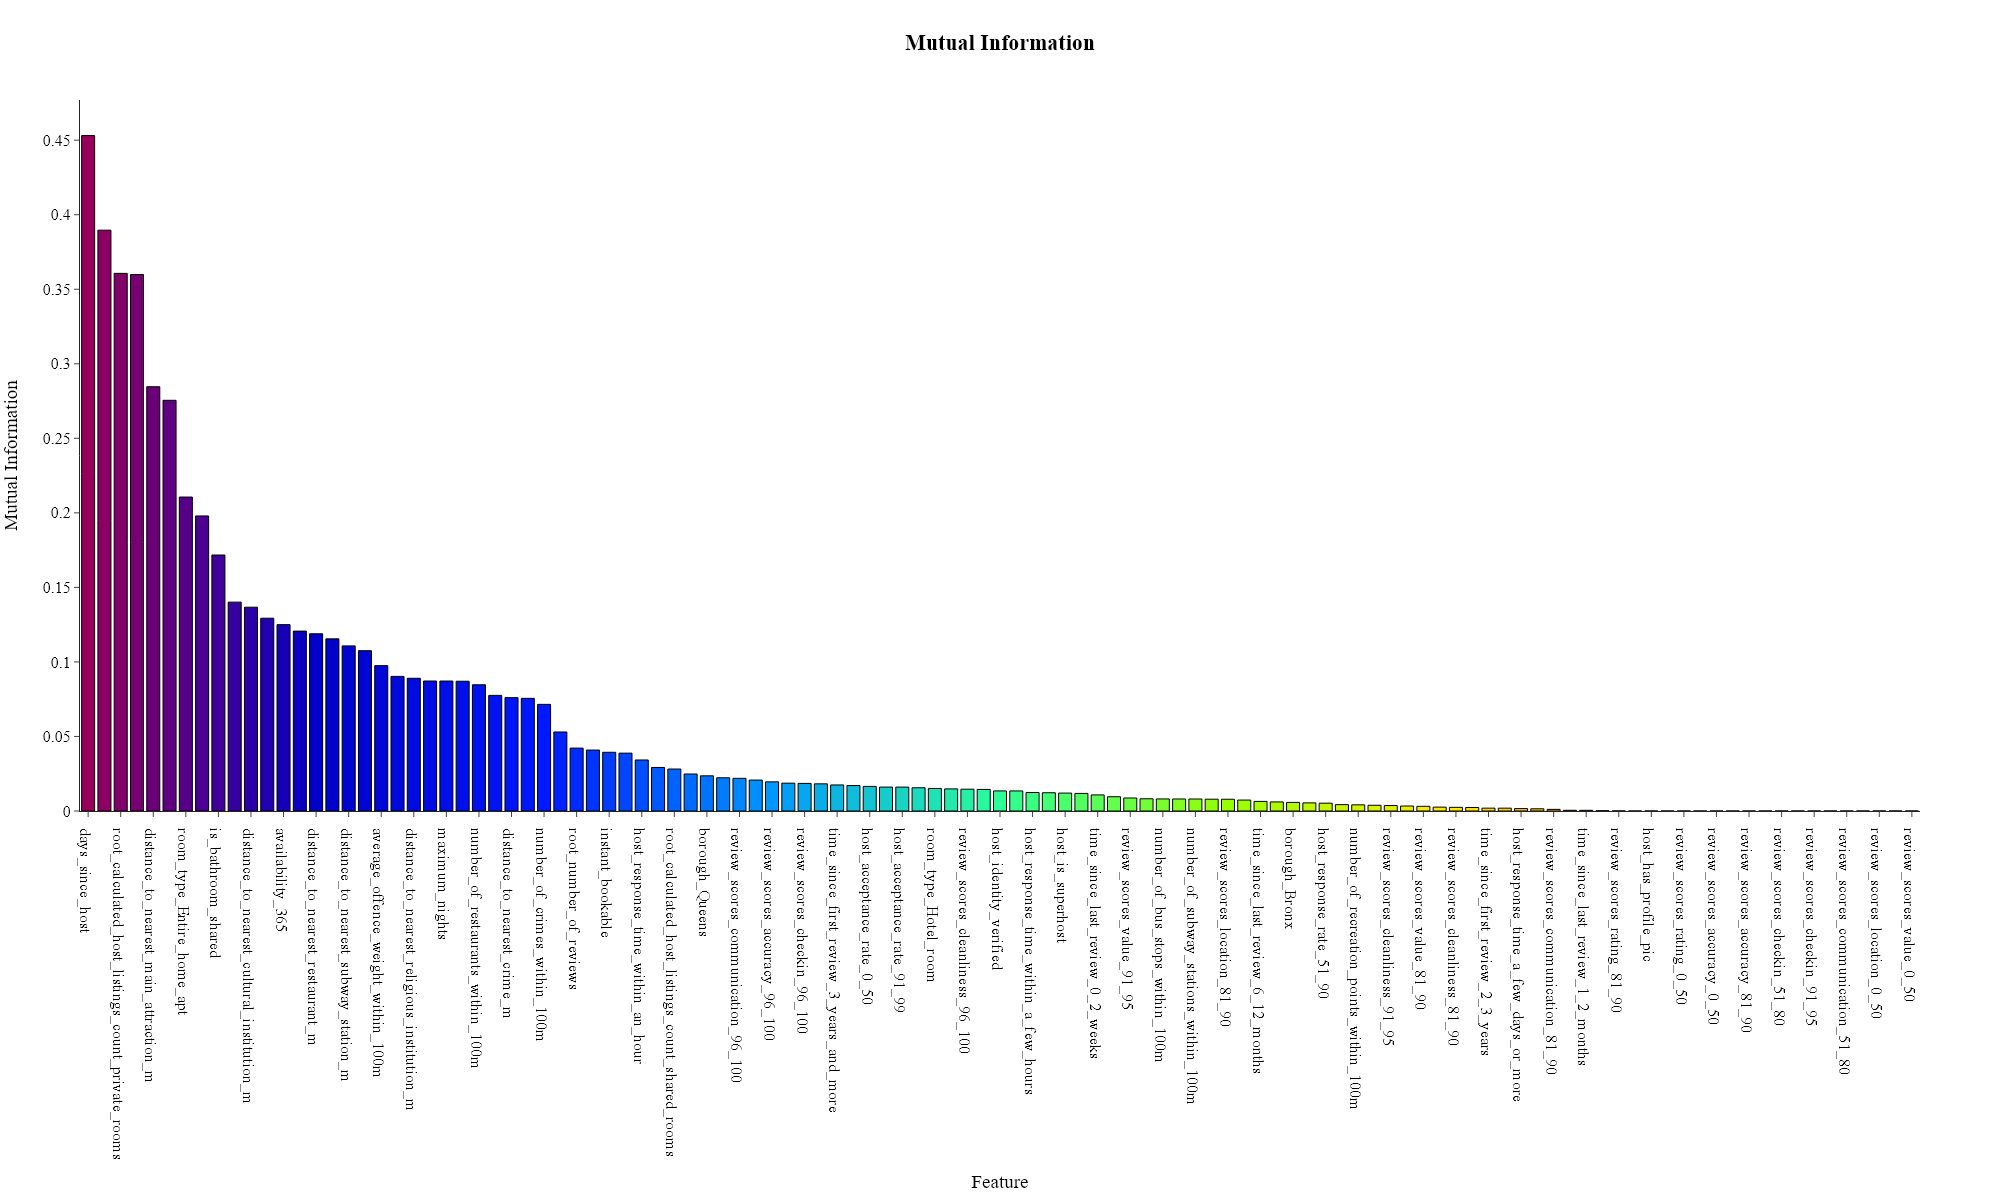

In [23]:
mi_scores = {feature: mutual_info_regression(data[[feature]], data[target_feature], random_state=SEED)[0] for feature in independent_features}
mi_scores = {k: v for k, v in sorted(mi_scores.items(), key=lambda item: item[1], reverse=True)}
fig = go.Figure()
n_colors = len(mi_scores)
colors = px.colors.sample_colorscale("rainbow", [n/(n_colors -1) for n in range(n_colors)])
fig.add_trace(go.Bar(x=list(mi_scores.keys()), y=list(mi_scores.values()), marker=dict(color=colors, line=dict(color='black', width=1), line_color='black')))
fig.update_layout(template="simple_white", width=2000, height=1200, title="<b>Mutual Information<b>", title_x=0.5, xaxis_title="Feature", yaxis_title=f"Mutual Information", font=dict(family="Times New Roman",size=16,color="Black"), showlegend=False)
fig.show("png")

**Notes:**
- There are a lot of features and therefore graph is not as readable as we would like it to be.

**Conclusion:**
- I will plot only top first 20 features based on mutual information score.

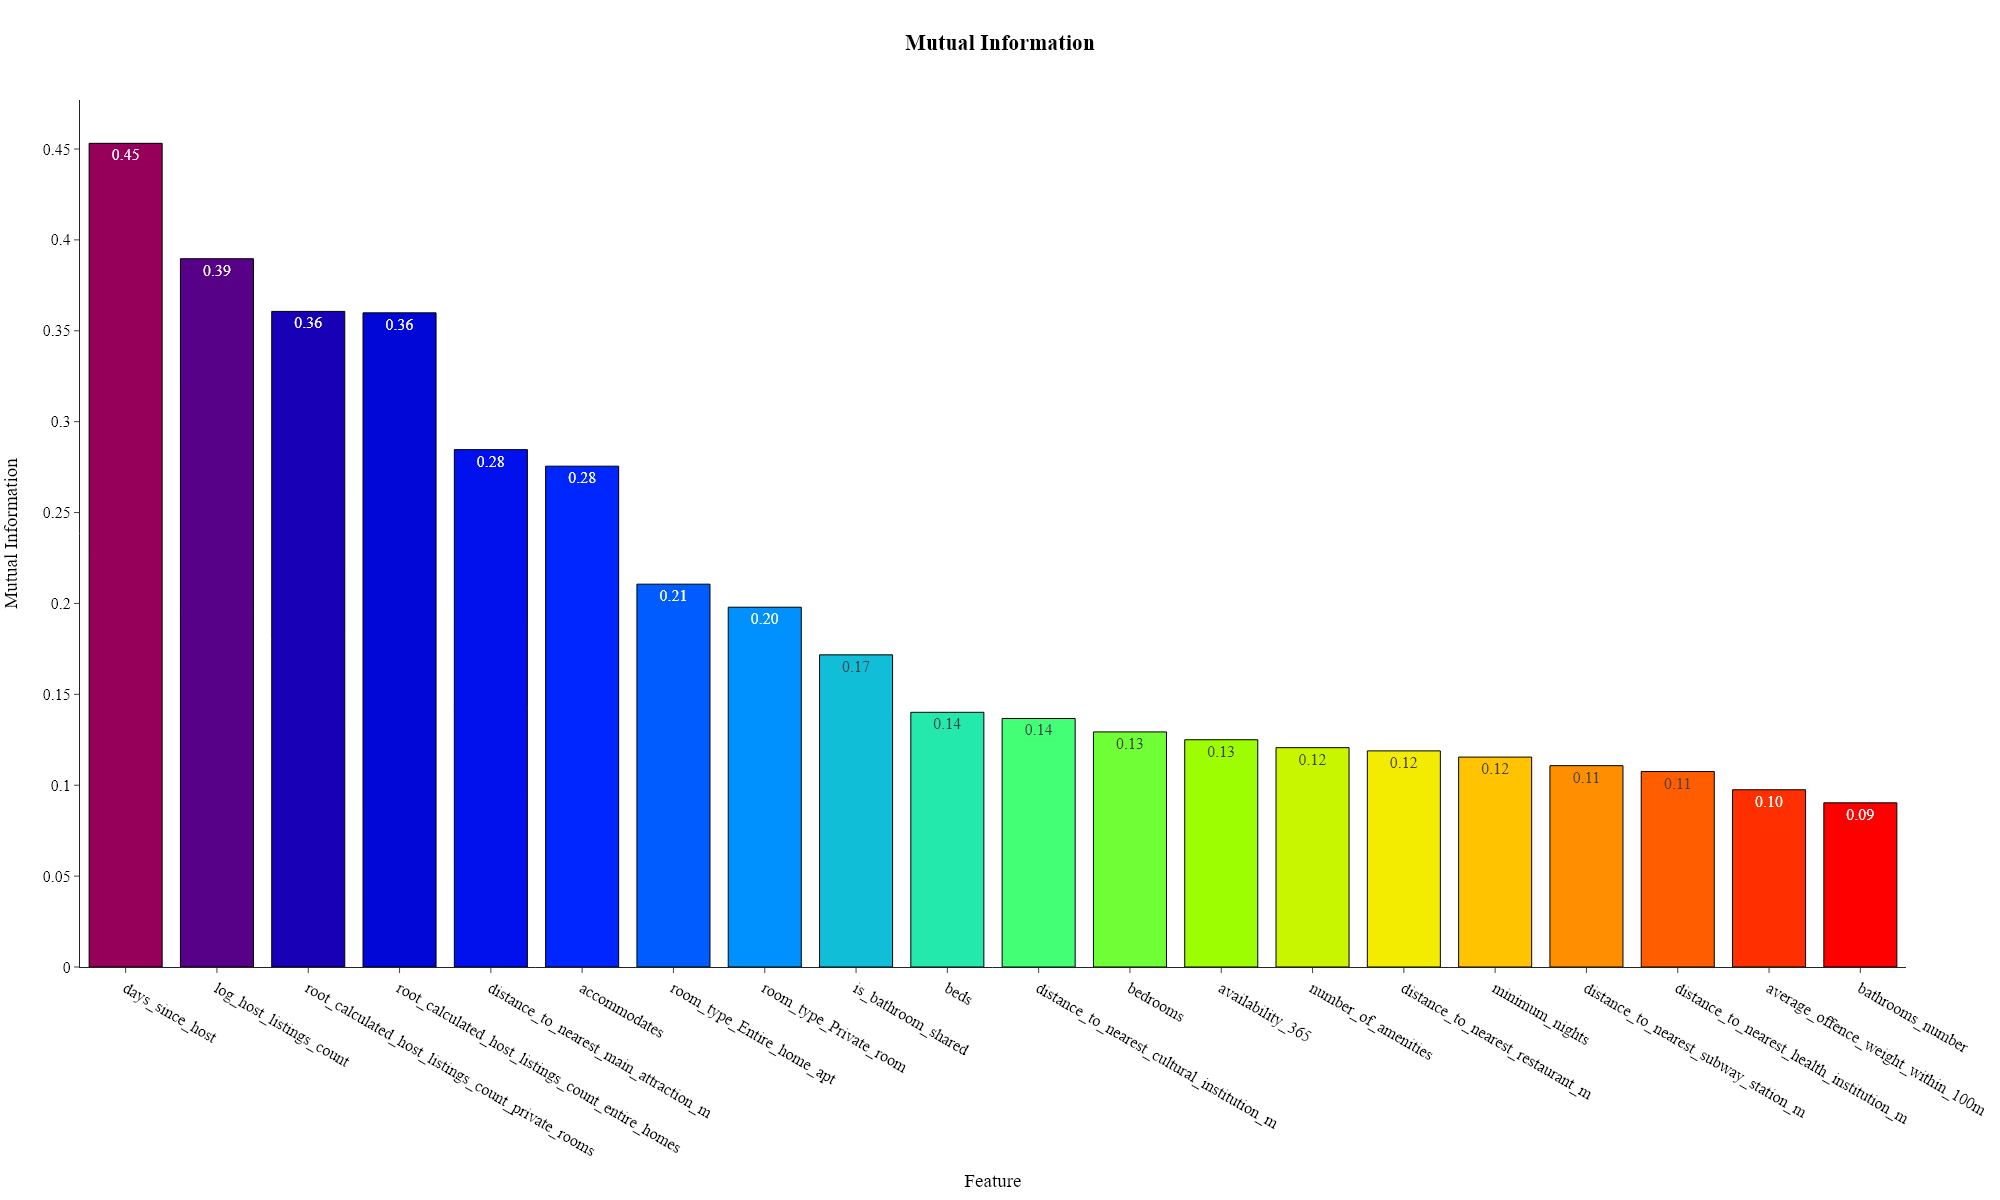

In [24]:
mi_top_features = {k: mi_scores[k] for k in list(mi_scores.keys())[:20]}
fig = go.Figure()
n_colors = len(mi_top_features)
colors = px.colors.sample_colorscale("rainbow", [n/(n_colors -1) for n in range(n_colors)])
fig.add_trace(go.Bar(x=list(mi_top_features.keys()), y=list(mi_top_features.values()), marker=dict(color=colors, line=dict(color='black', width=1), line_color='black'), text=[f"{v:.2f}" for v in list(mi_top_features.values())], textposition="auto"))
fig.update_layout(template="simple_white", width=2000, height=1200, title="<b>Mutual Information<b>", title_x=0.5, xaxis_title="Feature", yaxis_title=f"Mutual Information", font=dict(family="Times New Roman",size=16,color="Black"), showlegend=False)
fig.show("png")

**Notes:**
- The highest mutual information score for categorical feature is for `days_since_host` and most informative continous feature is `log_host_listings_count`.
- Based on previous plot we can also see that plenty of independent variables have Mutual Information score close to 0, which means that they are not informative.

## Dimensionality reduction

After analyzing continous and categorical features, we can see that some of them are not associated with target variable.

We can use various techniques to reduce dimensionality of dataset, which will help us to avoid curse of dimensionality and improve model performance.

Before applying any of these techniques, it is good practice to check whether we should reduce dimensionality of dataset.

We will use two techniques to check that: 

- Kaiser-Meyer-Olkin (KMO) test

- Bartlett's test of sphericity

## KMO test

Kaiser-Meyer-Olkin (KMO) is an index that compares partial correlation coefficients with the full correlation coefficients. It ranges from 0 to 1. Values closer to 1 indicate that the dataset is suitable for factor analysis.

In [25]:
def Kaiser_Mayer_Olkin(data):
    dataframe = pd.DataFrame(data)
    corr = dataframe.corr(method="spearman")
    corr = np.asarray(corr)
    corr_inv = np.linalg.inv(corr)
    kmo_numerator = np.sum(np.square(corr)) - np.sum(np.square(np.diag(corr)))
    partial_corr = np.zeros((corr.shape[0], corr.shape[0]))
    for i in range(corr.shape[0]):
        for j in range(corr.shape[0]):
            partial_corr[i, j] = -corr_inv[i, j]/np.sqrt(corr_inv[i, i]*corr_inv[j, j])
            partial_corr[j, i] = partial_corr[i, j]
    kmo_denominator = kmo_numerator + np.sum(np.square(partial_corr)) - np.sum(np.square(np.diag(partial_corr)))
    return kmo_numerator/kmo_denominator

print("KMO: ", Kaiser_Mayer_Olkin(data[continuous_features]))

KMO:  0.717705781627159


Kaiser-Meyer-Olkin (KMO) test is equal to 0.7177, which is above 0.5 and indicates that the dataset is suitable for factor analysis.

Bartlett's test of sphericity is a statistical test that tests the null hypothesis that the correlation matrix is an identity matrix. 

In other words, it tests whether the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix.

In [26]:
def bartlett_sphercity(data: typing.Union[np.ndarray]) -> tuple:
    """
    Perform Bartlett's Sphercity test.

    Args:
        data (np.ndarray): data to be tested.

    Returns:
        chi_square (float): chi square test statistic.
        p_value (float): p value.
    """
    corr_matrix = np.corrcoef(data, rowvar=False)
    N = data.shape[0]
    M = data.shape[1]
    chi_square = -(N - 1 - (2 * M - 5) / 6) * np.log(np.linalg.det(corr_matrix))
    degrees_of_freedom = (M**2 - M) / 2
    p_value = 1 - chi2.cdf(x=chi_square, df=degrees_of_freedom)
    return chi_square, p_value

test_statistic, pvalue = bartlett_sphercity(data[continuous_features])
print("Test Statistic: {}".format(np.round(test_statistic, 4)))
print("p_value: {}".format(np.round(pvalue, 4)))

Test Statistic: 371704.6025
p_value: 0.0


Test statistic is very high and p-value is equal to 0.0, which means that the correlation matrix is not an identity matrix and the variables are significantly correlated.

So it looks like PCA is appropriate for the dataset.

Principal Component Analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components.

We will use PCA to reduce dimensionality of dataset.

However, before applying PCA we have to scale the data, so that all features have the same scale.

Because in our dataset we have some features that are binary and some that are continous, we will use MinMaxScaler to scale the data to the range [0, 1].

In [27]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_transformed = data.copy()
data_transformed.drop(target_feature, axis=1, inplace=True)
data_transformed[continuous_features] = scaler.fit_transform(data_transformed[continuous_features])
data_transformed

,host_is_superhost,host_has_profile_pic,host_identity_verified,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_30,availability_365,...,number_of_education_institutions_within_100m,distance_to_nearest_cultural_institution_m,number_of_cultural_institutions_within_100m,distance_to_nearest_recreation_point_m,number_of_recreation_points_within_100m,distance_to_nearest_religious_institution_m,number_of_religious_institutions_within_100m,distance_to_nearest_health_institution_m,number_of_health_institutions_within_100m,distance_to_nearest_main_attraction_m
listing_id,,,,,,,,,,,,,,,,,,,,,
2595,0,1,1,0.000000,0.0000,0.023810,1.0,1.000000,0.000000,0.679452,...,0.000000,0.077705,0.0,0.057576,0.125,0.059417,0.0,0.100271,0.0,0.018241
5121,0,1,1,0.066667,0.0625,0.023810,1.0,0.132562,0.000000,0.638356,...,0.052632,0.033634,0.0,0.121594,0.000,0.075383,0.0,0.106963,0.0,0.211064
5136,0,1,1,0.200000,0.1250,0.047619,1.0,0.648577,0.000000,0.331507,...,0.052632,0.122988,0.0,0.291764,0.000,0.106273,0.0,0.081154,0.0,0.190703
6848,1,1,1,0.133333,0.1250,0.023810,1.0,0.648577,0.000000,0.430137,...,0.052632,0.129473,0.0,0.094256,0.000,0.259187,0.0,0.116228,0.0,0.186370
6872,0,1,1,0.000000,0.0625,0.023810,1.0,0.159253,1.000000,1.000000,...,0.000000,0.167666,0.0,0.084041,0.000,0.082799,0.0,0.034582,0.0,0.103794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237082867457012401,0,1,1,0.066667,0.0625,0.023810,1.0,0.323843,0.000000,0.912329,...,0.157895,0.168502,0.0,0.200489,0.000,0.141997,0.0,0.035474,0.0,0.049717
1237100764139053201,0,1,1,0.466667,0.1875,0.071429,1.0,0.323843,0.800000,0.983562,...,0.000000,0.069049,0.0,0.288695,0.000,0.076251,0.0,0.184895,0.0,0.025965
1237358247584723886,1,1,1,0.000000,0.0625,0.023810,1.0,0.168149,1.000000,0.997260,...,0.000000,0.084241,0.0,0.092505,0.000,0.064994,0.0,0.069082,0.0,0.305174


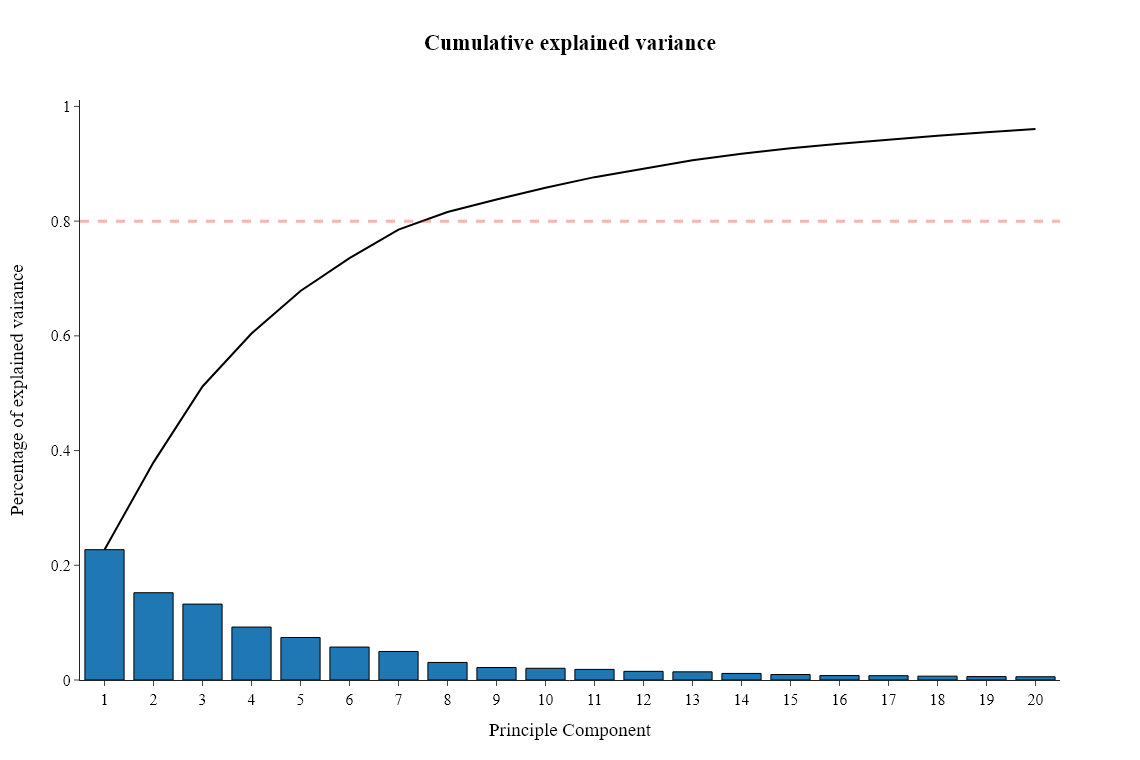

In [28]:
def cumulative_explained_variance(fitted_pca):
    labels = [i+1 for i in range(0, fitted_pca.components_.shape[1])]
    fig = go.Figure()
    fig.add_trace(go.Bar(x=labels, y=fitted_pca.explained_variance_ratio_, marker=dict(line=dict(color='black', width=1))))
    fig.add_trace(go.Scatter(x=labels, y=np.cumsum(fitted_pca.explained_variance_ratio_), marker=dict(line=dict(color='black', width=1)), line=dict(color="black")))
    fig.update_layout(template="simple_white", width=max(30*len(labels), 600), height=max(20*len(labels), 600), title=f"<b>Cumulative explained variance<b>", title_x=0.5, yaxis_title="Percentage of explained vairance", xaxis=dict(title='Principle Component', showticklabels=True, type="category"), font=dict(family="Times New Roman",size=16,color="Black"), showlegend=False)
    fig.add_hline(y=0.8, line_dash="dash", line_color="red", line_width=3)
    fig.show("png")

pca_transformer = PCA(n_components=20, random_state=SEED)
pca_transformer.fit(data_transformed[continuous_features])
cumulative_explained_variance(pca_transformer)

**Notes:**
- As we can see, first 8 principal components explain ~80% of variance in the dataset.
- It is pretty good result knowing that 8 components can explain 4/5 of variance that is present in the dataset with 38 continous features.

**Conclusion:**
- The main problem with PCA is that it is hard to interpret the results, because the components are linear combinations of original features, so after applying PCA we lose the original meaning of features. Therefore, we will not use PCA in this project.

# Outliers detection

This section will be focused on detecting outliers in the dataset.

## Isolation Forest

The first method that we will use to detect outliers is Isolation Forest.

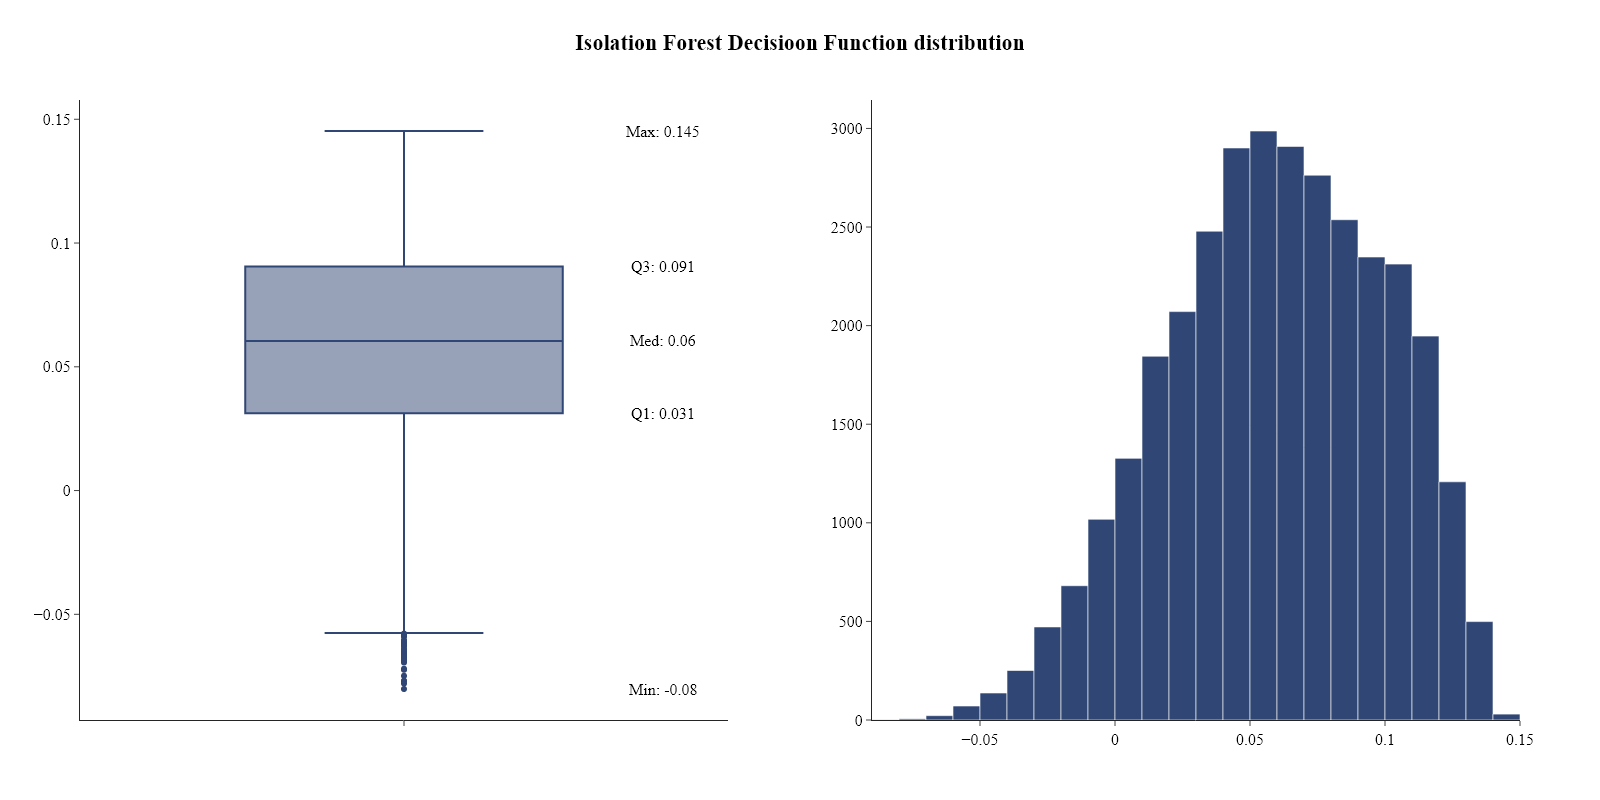

Number of outliers: 2659.
Proportion of outliers: 8.1%.


In [29]:
def histogram_and_box_plot(data, name="", annotations=True, bin_size=1):
    quantiles_dict = {"Min": 0, "Q1": 0.25, "Med": 0.5, "Q3": 0.75, "Max": 1}
    data = np.array(data).squeeze()
    fig = make_subplots(rows=1, cols=2, specs=[[{"type": "histogram"}, {"type": "box"}]])
    fig.add_trace(go.Box(y=data, name='', marker=dict(color="rgb(48,70,116)"), showlegend=False), row=1, col=1)
    fig.add_trace(go.Histogram(x=data, marker=dict(color="rgb(48,70,116)"), showlegend=False, xbins=dict(size=bin_size)), row=1, col=2)
    if type(annotations) == list:
        for x in annotations:
            fig.add_annotation(x=0.4, y=np.quantile(data, quantiles_dict[x]), text=x + ": " + str(np.round(np.quantile(data, quantiles_dict[x]), 3)), showarrow=False)
    elif type(annotations) == bool:
        if annotations:
            for key, value in quantiles_dict.items():
                fig.add_annotation(x=0.4, y=np.quantile(data, value), text=key + ": " + str(np.round(np.quantile(data, value), 3)), showarrow=False)
    fig.update_layout(template="simple_white", width=1600, height=800, title=f"<b>{name.title()} distribution<b>", title_x=0.5, font=dict(family="Times New Roman",size=16,color="Black"))
    fig.show("png")

isolation_forest = IsolationForest(random_state=SEED, n_jobs=-1)
isolation_forest.fit(data[independent_features])
histogram_and_box_plot(data=isolation_forest.decision_function(data[independent_features]), name="Isolation Forest decisioon function", annotations=True, bin_size=0.01)
outliers = isolation_forest.predict(data[independent_features])
outliers = pd.Series(outliers)
print("Number of outliers: {}.".format(outliers[outliers == -1].shape[0]))
print("Proportion of outliers: {}%.".format(np.round(outliers[outliers == -1].shape[0] / data.shape[0] * 100, 2)))

**Notes:**
- Based on Isolation Forest algorithm there are more than 6.81% of outliers in the dataset.

**Conclusion:**
- To have a better understanding of outliers we will plot them on the scatter plot but before that we will need to reduce the dimensionality of the dataset.  

We will use UMAP for that which similar to PCA is a dimensionality reduction technique, but it is more suitable for non-linear data.

However similarly to PCA, UMAP requires scaling of the data, so we will use dataset which was created in previous cells.

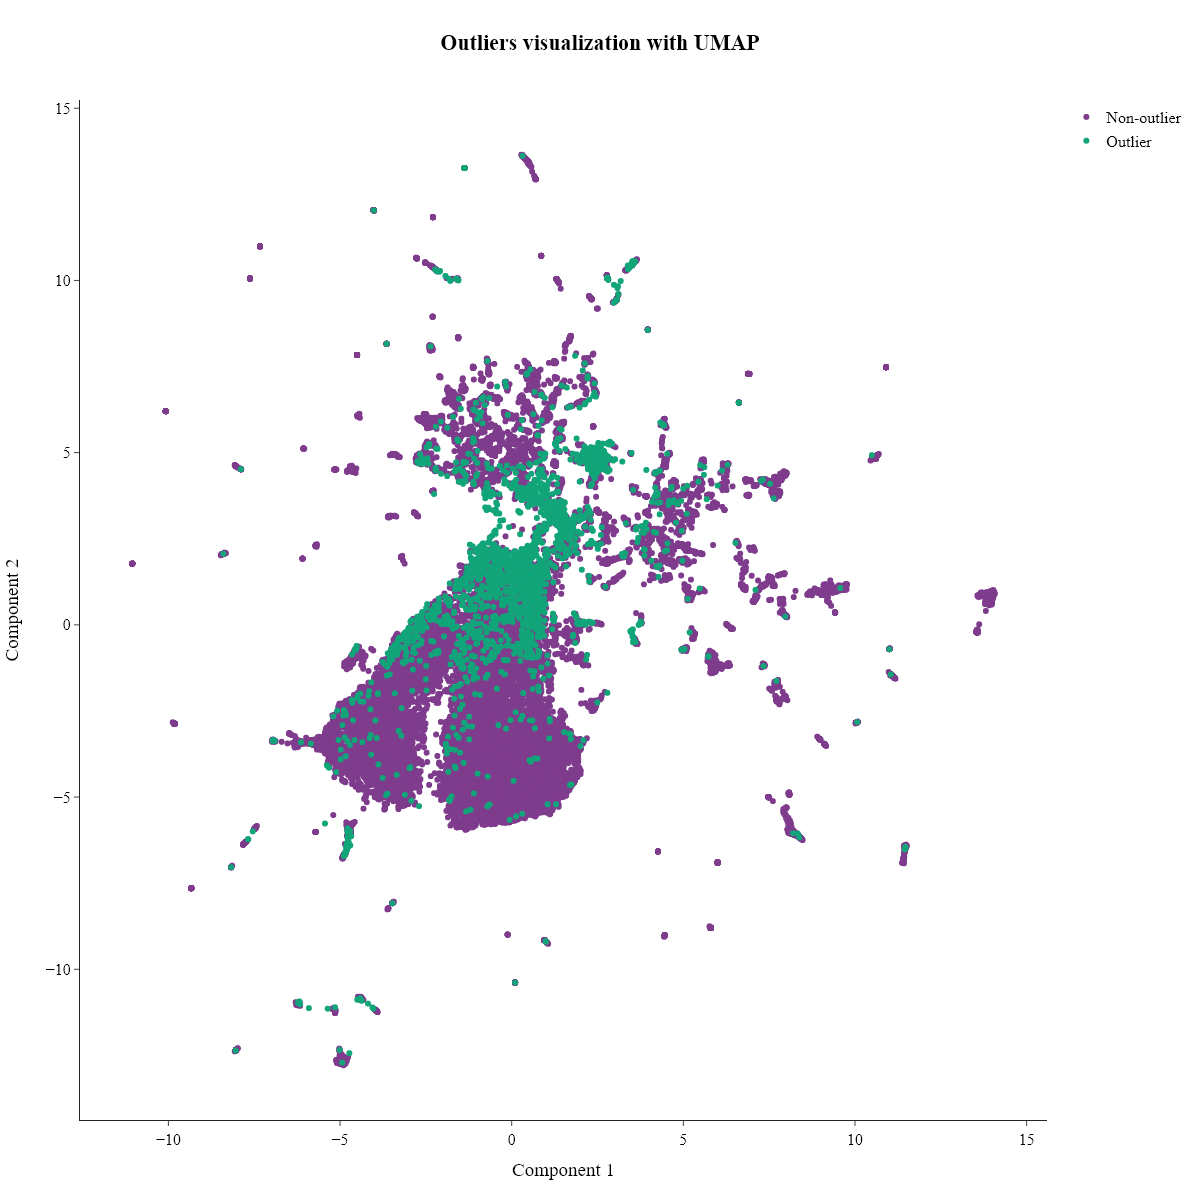

In [30]:
def scatter_plot(data, hue, name=""):
    data = np.array(data)
    hue = np.array(hue).squeeze()
    fig = go.Figure()
    unique_hue, freq = np.unique(hue, return_counts=True)
    hue_freq = dict(zip(unique_hue, freq))
    hue_freq = dict(sorted(hue_freq.items(), key=lambda item: item[1], reverse=True))
    colors = px.colors.qualitative.Bold
    outlier = False
    for idx, hue_value in enumerate(hue_freq.keys()):
        if hue_value == -1:
            outlier = True
        fig.add_trace(go.Scatter(x=data[hue == hue_value, 0], y=data[hue == hue_value, 1], mode='markers', marker=dict(color=colors[idx], showscale=False), showlegend=True, name="Outlier" if outlier else "Non-outlier"))
    fig.update_xaxes(title_text="Component 1")
    fig.update_yaxes(title_text="Component 2")
    fig.update_layout(template="simple_white", width=1200, height=1200, title=f"<b>{name}<b>", title_x=0.5, font=dict(family="Times New Roman",size=16,color="Black"))
    fig.show("png")

umap_reducer = UMAP(n_components=2, random_state=SEED)
X_umap = umap_reducer.fit_transform(data_transformed[independent_features])
scatter_plot(data=X_umap, hue=outliers, name="Outliers visualization with UMAP")

**Notes:**
- The plot does not show any clear pattern of outliers, we can see that they are spread across the whole dataset.
- That indicates that the problem might be with outliers detection method or UMAP did not reduce the dimensionality of dataset properly.

**Conclusion:**
- We will not drop any outliers based on Isolation Forest algorithm.

# Save data after EDA to DB

In [31]:
table_name = "airbnb_data"
drop_table_script = f"""
DROP TABLE IF EXISTS {table_name};
"""
cursor.execute(drop_table_script)

In [32]:
columns_names_and_types = dict(zip(data.columns, data.dtypes.tolist()))
columns_names_and_types = {k: str(v) for k, v in columns_names_and_types.items()}
python2sql_dtype = {'int64': 'INT', 'float64': 'FLOAT'}
create_script = f"CREATE TABLE {table_name} ({', '.join([f'{k} {python2sql_dtype[v]} NOT NULL' for k, v in columns_names_and_types.items()])});"
cursor.execute(create_script)
DB.commit()

In [33]:
# Insert data into the table
column_names = ', '.join([column for column in data.columns])
values_string = ', '.join(['%s' for _ in range(len(data.columns))])
insert_script = f"INSERT INTO {table_name} ({column_names}) VALUES ({values_string})"
values = data.values.tolist()
values = [[None if pd.isnull(value) else value.strftime('%Y-%m-%d') if (isinstance(value, pd.Timestamp)) else int(value) if (isinstance(value, int)) else value for value in row] for row in values]
cursor.executemany(insert_script, values)
DB.commit()